# Analysis IceCube Data

In [1]:
# !pip install mrmr_selection
# !pip install seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as op
import uncertainties.unumpy as unp
from uncertainties import ufloat
import scipy.constants as const
from scipy.optimize import curve_fit
from uncertainties.unumpy import nominal_values as noms
from uncertainties.unumpy import std_devs as stds
import pandas as pd
import seaborn as sn

import mrmr

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [3]:
# import data
signal = pd.read_csv('content/data/signal_train.csv', sep=',')
background = pd.read_csv('content/data/background_train.csv', sep=',')

## Preparation of the Data

In [4]:
# print(background["label"])
# print(signal["label"])

# bg label = 0; signal label = 1

In [5]:
df = pd.concat((signal, background))
keys = df.columns.values

mcTruths = ["Weight", "MC","Corsica", "I3EventHeader"]

for feature in keys:  
    # Remove MC truths
    if any(substring in feature for substring in mcTruths):
        df.drop(columns=[feature], inplace=True)



# Dropping all features with more than .x NaN or inf
threshold = 0.1
max_invalid_count = int(threshold * len(df))

df.replace({np.inf: np.nan, -np.inf: np.nan}, inplace=True) # Replace inf with NaN
nan_counts = df.isna().sum()
cols_to_drop = nan_counts[nan_counts > max_invalid_count].index
df.drop(columns=cols_to_drop, inplace=True)

# Dropping all rows that still have NaN or inf
df.dropna(inplace=True)

# # Initialize the scaler
# scaler = StandardScaler()

# # Fit and transform the data
# X = scaler.fit_transform(df)

# # Convert the transformed data back to a DataFrame
# df = pd.DataFrame(X, columns=df.columns)

## Attribute Selection

In [6]:
# df need further treatment... save labels and drop them
label = df["label"]
df.drop(columns=["label"], inplace=True)
keys_new = df.columns.values

In [7]:
features_class = mrmr.mrmr_classif(X=df, y=label, K=100) ## determine the best 100 features in order 

100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


In [8]:
print(features_class)

['LineFit_TTParams.lf_vel_z', 'SplineMPEDirectHitsC.n_dir_strings', 'HitStatisticsValues.z_travel', 'SplineMPEFitParams.rlogl', 'SplineMPECharacteristics.avg_dom_dist_q_tot_dom', 'LineFit_TT.zenith', 'SplineMPEDirectHitsA.n_dir_strings', 'MuEXAngular4.zenith', 'NewAtt.SplineVerRadius', 'SplineMPE.zenith', 'MuEXAngular4_Sigma.value', 'SplineMPEDirectHitsA.n_dir_doms', 'MPEFitHighNoise.zenith', 'MPEFit_TTFitParams.rlogl', 'SplineMPEMuEXDifferential.zenith', 'NewAtt.DeltaZd', 'SplineMPETruncatedEnergy_SPICEMie_AllBINS_Muon.zenith', 'SplineMPEDirectHitsC.dir_track_length', 'SPEFit2_TT.zenith', 'SplineMPETruncatedEnergy_SPICEMie_AllDOMS_Muon.zenith', 'NewAtt.radius', 'MPEFitHighNoiseFitParams.rlogl', 'MPEFit_TT.zenith', 'MPEFitParaboloid.zenith', 'SplineMPECharacteristics.track_hits_separation_length', 'MPEFitParaboloidFitParams.zenith', 'SplineMPETruncatedEnergy_SPICEMie_AllDOMS_MuEres.value', 'SPEFit2Bayesian.z', 'LineFit_TTParams.lf_vel', 'SplineMPETruncatedEnergy_SPICEMie_AllBINS_MuEres

In [9]:
# Plot n best and n worst features
n = 3 
plt.close()
fig, ax = plt.subplots(1,n,figsize=(10, 5))
for i in range(n):
    ax[i].hist(background[features_class[i]], histtype="step", label="BG")
    ax[i].hist(signal[features_class[i]], histtype="step", label="Signal")
    ax[i].set_xlabel(features_class[i], labelpad=1.0)
    ax[i].set_ylabel("Counts")
    ax[i].legend()
fig.tight_layout()
plt.savefig(f"content/plots/best_{n}_features.pdf")
plt.close()

fig, ax = plt.subplots(1,n,figsize=(10, 5))
for i in range(n):
    ax[i].hist(background[features_class[len(features_class)-i-1]], histtype="step", label="BG")
    ax[i].hist(signal[features_class[len(features_class)-i-1]], histtype="step", label="Signal")
    ax[i].set_xlabel(features_class[len(features_class)-i-1], labelpad=1.0, fontsize=8)
    ax[i].set_ylabel("Counts")
    ax[i].legend()
fig.tight_layout()
plt.savefig(f"content/plots/worst_{n}_features.pdf")
plt.close()

## Multivariate Selection

In [10]:
# defining the accuracy, precision, recall, f_beta score used later
def accuracy(TP,FP,TN,FN):
    return (TP + TN) / (TP + TN + FP + FN)

def precision(TP, FP):
    return TP / (TP + FP) if (TP + FP) > 0 else 0.0

def recall(TP, FN):
    return TP / (TP + FN) if (TP + FN) > 0 else 0.0

def f_beta(TP, FP, FN, beta=0.1):
    p = precision(TP, FP)
    r = recall(TP, FN)
    # if p + r == 0:
    #     return 0
    return (1 + beta**2) * (p * r) / (beta**2 * p + r) if p+r !=0 else 0

### Naive Bayes model

In [11]:
# Naive Bayes model
features_used_naive = 10
X_naive = df[features_class[:features_used_naive]]
kfold_naive = KFold(n_splits=5, shuffle=True) ## kfolding with shuffling
cv_result_naive = cross_validate(GaussianNB(), X_naive, label, scoring=["accuracy", "precision", "roc_auc"], cv = kfold_naive, return_estimator=True)
print("")
print(f"GaussianNB Cross validation result:")
print(f"Accuracy: {ufloat(np.mean(cv_result_naive['test_accuracy']),np.std(cv_result_naive['test_accuracy']))}")
print(f"Precision: {ufloat(np.mean(cv_result_naive['test_precision']),np.std(cv_result_naive['test_precision']))}")
#print(f"Recall: {ufloat(np.mean(cv_result['test_recall']),np.std(cv_result['test_recall']))}") #not provided in this function
print(f"ROC: {ufloat(np.mean(cv_result_naive['test_roc_auc']),np.std(cv_result_naive['test_roc_auc']))}")
print("")

# Use the first trained estimator from the cross-validation result
trained_model_naive = cv_result_naive['estimator'][0]

# Predict probabilities using the trained model
y_pred_proba_naive = trained_model_naive.predict_proba(X_naive) # (data, label)

accuracy_list_naive = []
precision_list_naive = [] 
recall_list_naive = []
f_beta_list_naive = []

threshold_naive = np.linspace(0,1,100)
for t in threshold_naive:
    y_pred_naive = (y_pred_proba_naive[:,1] > t)#.astype(int)
    conf_mat_naive = confusion_matrix(label, y_pred_naive)
    TP = conf_mat_naive[1][1]
    FP = conf_mat_naive[0][1]
    TN = conf_mat_naive[0][0]
    FN = conf_mat_naive[1][0]
    
    accuracy_list_naive.append(accuracy(TP,FP,TN,FN))
    precision_list_naive.append(precision(TP,FP))
    recall_list_naive.append(recall(TP,FN))
    f_beta_list_naive.append(f_beta(TP,FP,FN, 0.1))

# best threshold value
t_best_naive = threshold_naive[np.argmax(f_beta_list_naive)]

print(f"t_best_naive = {t_best_naive:.4f}")


GaussianNB Cross validation result:
Accuracy: 0.827+/-0.005
Precision: 0.873+/-0.008
ROC: 0.921+/-0.005

t_best_naive = 0.9899


### Plots Naive Bayes

In [12]:

fig, ax = plt.subplots()

ax.plot(threshold_naive, accuracy_list_naive, label = "Accuracy")
ax.plot(threshold_naive, precision_list_naive, label = "Precision")
ax.plot(threshold_naive, recall_list_naive, label = "Recall")
ax.plot(threshold_naive, f_beta_list_naive, linestyle="dotted", label = r"$f_{\beta}$")

ax.set_xlabel(r"Threshold $t$")
ax.legend()

fig.savefig("content/plots/apr_naive.pdf")
plt.close()


fig, ax = plt.subplots()

ax.plot(threshold_naive, f_beta_list_naive, label = r"$f_{\beta}$")
ax.vlines(t_best_naive,0.82,0.9, linestyles="dashed", colors="firebrick", label = r"$t_{\mathrm{best}}$ = " + f"{t_best_naive:.4f}")
ax.set_xlabel(r"Threshold $t$")
ax.legend()
ax.set_ybound(0.87,0.9)
ax.set_xbound(0.9,1.0)

fig.savefig("content/plots/f_beta_naive.pdf")
plt.close()

y_pred_naive = (y_pred_proba_naive[:,1] > t_best_naive)#.astype(int)
c_mat_naive = confusion_matrix(label, y_pred_naive)
ax = sn.heatmap(c_mat_naive, annot=True, fmt='g',cbar_kws={'label': 'Counts'})
ax.set(xlabel="True label", ylabel="Predicted label")
plt.tight_layout()
plt.savefig(f'content/plots/confusion_naive.pdf')
plt.close()
# Compute ROC curve and ROC AUC score
FP_naive, TP_naive, thresholds = roc_curve(label, y_pred_proba_naive[:, 1], pos_label=1)

roc_auc_naive = roc_auc_score(label, y_pred_proba_naive[:, 1])



### Random forest model

In [13]:
# Random Forest model
features_used_rdm = 10
X_rdm = df[features_class[:features_used_rdm]]
kfold_rdm = KFold(n_splits=5, shuffle=True) ## kfolding with shuffling
cv_result_rdm = cross_validate(RandomForestClassifier(), X_rdm, label, scoring=["accuracy", "precision", "roc_auc"], cv = kfold_rdm, return_estimator=True)
print("")
print(f"RandomForestClassifier Cross validation result:")
print(f"Accuracy: {ufloat(np.mean(cv_result_rdm['test_accuracy']),np.std(cv_result_rdm['test_accuracy']))}")
print(f"Precision: {ufloat(np.mean(cv_result_rdm['test_precision']),np.std(cv_result_rdm['test_precision']))}")
#print(f"Recall: {ufloat(np.mean(cv_result['test_recall']),np.std(cv_result['test_recall']))}") #not provided in this function
print(f"ROC: {ufloat(np.mean(cv_result_rdm['test_roc_auc']),np.std(cv_result_rdm['test_roc_auc']))}")
print("")

# Use the first trained estimator from the cross-validation result
trained_model_rdm = cv_result_rdm['estimator'][0]

# Predict probabilities using the trained model
y_pred_proba_rdm = trained_model_rdm.predict_proba(X_rdm) # (data, label)

accuracy_list_rdm = []
precision_list_rdm = [] 
recall_list_rdm = []
f_beta_list_rdm = []

threshold_rdm = np.linspace(0,1,100)
for t in threshold_rdm:
    y_pred_rdm = (y_pred_proba_rdm[:,1] > t)#.astype(int)
    conf_mat_rdm = confusion_matrix(label, y_pred_rdm)
    TP = conf_mat_rdm[1][1]
    FP = conf_mat_rdm[0][1]
    TN = conf_mat_rdm[0][0]
    FN = conf_mat_rdm[1][0]
    
    accuracy_list_rdm.append(accuracy(TP,FP,TN,FN))
    precision_list_rdm.append(precision(TP,FP))
    recall_list_rdm.append(recall(TP,FN))
    f_beta_list_rdm.append(f_beta(TP,FP,FN, 0.1))

# best threshold value
t_best_rdm = threshold_rdm[np.argmax(f_beta_list_rdm)]

print(f"t_best_rdm = {t_best_rdm:.4f}")


RandomForestClassifier Cross validation result:
Accuracy: 0.9405+/-0.0029
Precision: 0.9550+/-0.0015
ROC: 0.9830+/-0.0015

t_best_rdm = 0.8990


### Plots Random Forest

In [14]:
fig, ax = plt.subplots()

ax.plot(threshold_rdm, accuracy_list_rdm, label = "Accuracy")
ax.plot(threshold_rdm, precision_list_rdm, label = "Precision")
ax.plot(threshold_rdm, recall_list_rdm, label = "Recall")
ax.plot(threshold_rdm, f_beta_list_rdm, linestyle="dotted", label = r"$f_{\beta}$")

ax.set_xlabel(r"Threshold $t$")
ax.legend()

fig.savefig("content/plots/apr_rdm.pdf")
plt.close()


fig, ax = plt.subplots()

ax.plot(threshold_rdm, f_beta_list_rdm, label = r"$f_{\beta}$")
ax.vlines(t_best_rdm,0.99,1.0, linestyles="dashed", colors="firebrick", label = r"$t_{\mathrm{best}}$ = " + f"{t_best_rdm:.4f}")
ax.set_xlabel(r"Threshold $t$")
ax.legend()
ax.set_ybound(0.99,1.0)
ax.set_xbound(0.8,0.9)

fig.savefig("content/plots/f_beta_rdm.pdf")
plt.close()

y_pred = (y_pred_proba_rdm[:,1] > t_best_rdm)
c_mat_rdm = confusion_matrix(label, y_pred)
ax = sn.heatmap(c_mat_rdm, annot=True, fmt='g',cbar_kws={'label': 'Counts'})
ax.set(xlabel="True label", ylabel="Predicted label")
plt.tight_layout()
plt.savefig(f'content/plots/confusion_rdm.pdf')
plt.close()
# Compute ROC curve and ROC AUC score
FP_rdm, TP_rdm, thresholds = roc_curve(label, y_pred_proba_rdm[:, 1], pos_label=1)

roc_auc_rdm = roc_auc_score(label, y_pred_proba_rdm[:, 1])

### kNN Model

In [15]:
# Naive Bayes model
features_used_kNN = 10
X_kNN = df[features_class[:features_used_kNN]]
kfold_kNN = KFold(n_splits=5, shuffle=True) ## kfolding with shuffling
cv_result_kNN = cross_validate(KNeighborsClassifier(n_neighbors=15), X_kNN, label, scoring=["accuracy", "precision", "roc_auc"], cv = kfold_kNN, return_estimator=True)
print("")
print(f"kNN Cross validation result:")
print(f"Accuracy: {ufloat(np.mean(cv_result_kNN['test_accuracy']),np.std(cv_result_kNN['test_accuracy']))}")
print(f"Precision: {ufloat(np.mean(cv_result_kNN['test_precision']),np.std(cv_result_kNN['test_precision']))}")
#print(f"Recall: {ufloat(np.mean(cv_result['test_recall']),np.std(cv_result['test_recall']))}") #not provided in this function
print(f"ROC: {ufloat(np.mean(cv_result_kNN['test_roc_auc']),np.std(cv_result_kNN['test_roc_auc']))}")
print("")

# Use the first trained estimator from the cross-validation result
trained_model_kNN = cv_result_kNN['estimator'][0]

# Predict probabilities using the trained model
y_pred_proba_kNN = trained_model_kNN.predict_proba(X_kNN) # (data, label)

accuracy_list_kNN = []
precision_list_kNN = [] 
recall_list_kNN = []
f_beta_list_kNN = []

threshold_kNN = np.linspace(0,1,100)
for t in threshold_kNN:
    y_pred_kNN = (y_pred_proba_kNN[:,1] > t)#.astype(int)
    conf_mat_kNN = confusion_matrix(label, y_pred_kNN)
    TP = conf_mat_kNN[1][1]
    FP = conf_mat_kNN[0][1]
    TN = conf_mat_kNN[0][0]
    FN = conf_mat_kNN[1][0]
    
    accuracy_list_kNN.append(accuracy(TP,FP,TN,FN))
    precision_list_kNN.append(precision(TP,FP))
    recall_list_kNN.append(recall(TP,FN))
    f_beta_list_kNN.append(f_beta(TP,FP,FN, 0.1))

# best threshold value
t_best_kNN = threshold_kNN[np.argmax(f_beta_list_kNN)]

print(f"t_best_kNN = {t_best_kNN:.4f}")


kNN Cross validation result:
Accuracy: 0.8821+/-0.0016
Precision: 0.885+/-0.007
ROC: 0.9400+/-0.0023

t_best_kNN = 0.9394


### Plots kNN

In [16]:
fig, ax = plt.subplots()

ax.plot(threshold_kNN, accuracy_list_kNN, label = "Accuracy")
ax.plot(threshold_kNN, precision_list_kNN, label = "Precision")
ax.plot(threshold_kNN, recall_list_kNN, label = "Recall")
ax.plot(threshold_kNN, f_beta_list_kNN, linestyle="dotted", label = r"$f_{\beta}$")

ax.set_xlabel(r"Threshold $t$")
ax.legend()

fig.savefig("content/plots/apr_kNN.pdf")
plt.close()


fig, ax = plt.subplots()

ax.plot(threshold_kNN, f_beta_list_kNN, label = r"$f_{\beta}$")
ax.vlines(t_best_kNN,0.9,1.0, linestyles="dashed", colors="firebrick", label = r"$t_{\mathrm{best}}$ = " + f"{t_best_kNN:.4f}")
ax.set_xlabel(r"Threshold $t$")
ax.legend()
ax.set_ybound(0.9,1.0)
ax.set_xbound(0.8,1.0)

fig.savefig("content/plots/f_beta_kNN.pdf")
plt.close()

y_pred = (y_pred_proba_kNN[:,1] > t_best_kNN)
c_mat_kNN = confusion_matrix(label, y_pred)
ax = sn.heatmap(c_mat_kNN, annot=True, fmt='g',cbar_kws={'label': 'Counts'})
ax.set(xlabel="True label", ylabel="Predicted label")
plt.tight_layout()
plt.savefig(f'content/plots/confusion_kNN.pdf')
plt.close()
# Compute ROC curve and ROC AUC score
FP_kNN, TP_kNN, thresholds = roc_curve(label, y_pred_proba_kNN[:, 1], pos_label=1)

roc_auc_kNN = roc_auc_score(label, y_pred_proba_kNN[:, 1])

ROC AUC score Naive Bayes: 	 0.9212
ROC AUC score Random Forest: 	 0.9979
ROC AUC score kNN: 		 0.9561


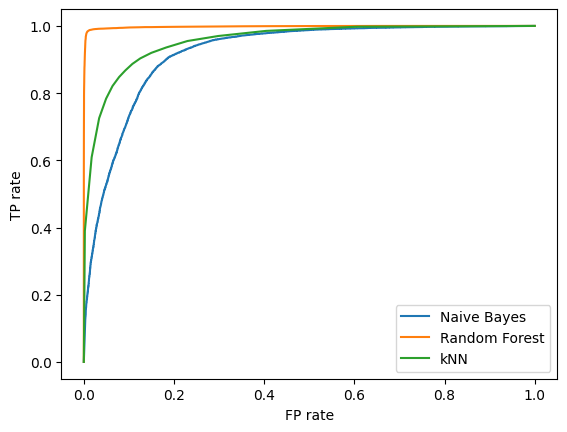

In [17]:
# Plot all ROCs together
fig, ax = plt.subplots()
ax.plot(FP_naive, TP_naive, label="Naive Bayes")
ax.plot(FP_rdm, TP_rdm, label = "Random Forest")
ax.plot(FP_kNN, TP_kNN, label = "kNN")

ax.legend()
ax.set_xlabel("FP rate")
ax.set_ylabel("TP rate")
fig.savefig("content/plots/ROC_all.pdf")
#plt.close()


print(f"ROC AUC score Naive Bayes: \t {roc_auc_naive:.4f}")
print(f"ROC AUC score Random Forest: \t {roc_auc_rdm:.4f}")
print(f"ROC AUC score kNN: \t\t {roc_auc_kNN:.4f}")

## Apply Random Forest on provided test dataset

In [31]:
## Random forest performes the best so lets use it
test = pd.read_csv('content/data/test.csv', sep=',')
X_test = test[keys_new]
X_test = X_test[features_class[:features_used_rdm]]
# X.replace(to_replace=np.nan, value=0, inplace=True) # stoopid nan
y_pred_proba = trained_model_rdm.predict_proba(X_test)
label_pred = y_pred_proba[:,1] > t_best_rdm
print(f"Number of predicted signals: {np.sum(label_pred)}")
print(f"BG: {len(label_pred)-np.sum(label_pred)}")
print(f"Total Data: {len(label_pred)}")

classification_test = pd.DataFrame(label_pred, columns=["label"])
classification_test.to_csv("build/classification_test.csv")
classification_test

Number of predicted signals: 1633
BG: 2367
Total Data: 4000


,label
0,True
1,False
2,False
3,False
4,False
...,...
3995,False
3996,False
3997,False
3998,False
